In [1]:
import math
import os
from tqdm import tqdm

from ray import tune
import numpy as np
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.nn.utils import clip_grad_norm
from torch.utils.data import random_split

from dataset.HighD_Dataset_DGL import HighD_Dataset
from dgl.dataloading import GraphDataLoader
from utils.util import AverageMeter

Using backend: pytorch


In [5]:
def eval(model, val_dataloader, device):
    losses = AverageMeter()
    model.to(device)
    model.eval()
    criterion = MyLoss()

    with tqdm(total=len(val_dataloader),desc='Validation round') as pbar:
        for i, (graph, X, Y, _mask) in enumerate(val_dataloader):
            # 先不采用batch训练
            graph = graph.to(device)
            X = X[0,...].to(device)
            Y = Y[0,...].to(device)
            # mask = mask[0,...].to(device)
            if X.shape[1]==0:
                continue

            ###### 临时！ 测试用mask
            mask = torch.ones_like(X,dtype=torch.uint8)  #[10,N,2]
            mask[9,np.random.randint(mask.shape[1]),:]=0
            mask = mask.to(device)

            output = model(graph, X*mask)  #[1,N,2]
            loss = criterion(output,Y,mask)

            losses.update(loss.item())
            pbar.set_description('Loss: {:.2f}'.format(loss.item()))
            pbar.update()

    return losses.avg

In [2]:
HighD_dataset = HighD_Dataset(X_len=10,X_step=1,Y_len=1,Y_step=1,diff=9,name='data_02',raw_dir='./dataset/',preprocess_all=False)
val_dataloader = GraphDataLoader(HighD_dataset, batch_size=1, shuffle=False)
print("Dataset Ready!")
# device = 'cpu'
# model = MyModel(num_feats=4, output_dim=4, hidden_size=64, num_layers=3,seq_len=10, horizon=1, device=device)
# model.load_state_dict(torch.load('ckpts/0329_testgpu/CP_epoch15_loss_2.6713295542438136.pth'))
# val_loss = eval(model, val_dataloader, device)
# print('validation loss = {}'.format(val_loss))

Dataset Ready!


In [3]:
val_dataloader = GraphDataLoader(HighD_dataset, batch_size=4, shuffle=False)

In [4]:
loader = enumerate(val_dataloader)

In [5]:
i, (X, Y) = loader.__next__()

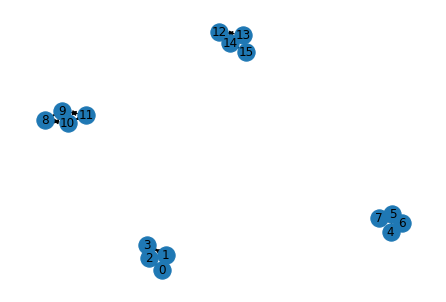

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

nx.draw(X[6].to_networkx(), with_labels=True)
plt.show()

In [19]:
output = torch.ones((1, 16, 2))
predict = output[0,X[-1].ndata['mask']==0].view(-1,2)
truth = Y[0].ndata['feature'][X[-1].ndata['mask']==0].view(-1,2)
print(X[-1].ndata['mask'])
print(Y[0].ndata['feature'])
print(truth)

tensor([[1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1]], dtype=torch.uint8)
tensor([[152.4600,   8.9400],
        [369.3800,  13.1700],
        [350.2800,   8.8100],
        [397.5200,   8.9300],
        [151.5000,   8.9400],
        [367.9200,  13.1700],
        [349.3100,   8.8100],
        [396.5900,   8.9300],
        [150.5400,   8.9300],
        [366.4700,  13.1800],
        [348.3400,   8.8100],
        [395.6500,   8.9200],
        [149.5700,   8.9300],
        [365.0100,  13.1800],
        [347.3900,   8.8000],
        [394.7100,   8.9100]])
tensor([[350.2800,   8.8100],
        [349.3100,   8.8100],
        [348.3400,   8.8100],
        [347.3900,   8.8000]])


In [21]:
aa = torch.ones((10))
for i in aa:
    print(i)

tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)


In [19]:
X = X[0,...]
Y = Y[0,...]

mask = torch.ones_like(X,dtype=torch.uint8)
rand_pos = np.random.randint(mask.shape[1])
mask[9,rand_pos,:]=0

rand_pos

2

In [20]:
output = model(graph, X*mask)

In [21]:
output

tensor([[[ 3.0515e+02,  6.9633e+00, -2.8576e+01,  2.8320e-02],
         [ 3.6686e+02,  8.2135e+00, -2.6156e+01,  7.7922e-03],
         [ 3.6660e+02,  8.1985e+00, -2.6116e+01,  5.1667e-03],
         [ 3.0515e+02,  6.9633e+00, -2.8576e+01,  2.8320e-02]]],
       grad_fn=<StackBackward>)

In [22]:
Y

tensor([[[ 1.4957e+02,  8.9300e+00, -2.3920e+01, -5.0000e-02],
         [ 3.6501e+02,  1.3180e+01, -3.6310e+01,  1.0000e-01],
         [ 3.4739e+02,  8.8000e+00, -2.3660e+01, -8.0000e-02],
         [ 3.9471e+02,  8.9100e+00, -2.3060e+01, -1.3000e-01]]])

In [25]:
os.mkdir('ckpts/2021-04-02 233516_cpu/')

In [11]:
a=[]
a.append(np.array([1,2,3]))
a.append(np.array([3,4,3]))
np.array(a).shape

(2, 3)